In [1]:
import sys
print(sys.version)
print(spark.version)

3.8.5 | packaged by conda-forge | (default, Aug 29 2020, 01:22:49) 
[GCC 7.5.0]
3.0.1


In [14]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', -1)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [3]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Load data

In [4]:
sqlContext = SQLContext(sc)
# reading the data
df_uchi = sqlContext.read.format("csv") \
   .options(header='true', inferschema='true') \
   .load('gs://msca-bigdata-1/notebooks/gchai/uchicago_data1.csv')

df_unl=sqlContext.read.format("csv") \
   .options(header='true', inferschema='true') \
   .load('gs://msca-bigdata-1/notebooks/gchai/unebraska_data1.csv')

df_north=sqlContext.read.format("csv") \
   .options(header='true', inferschema='true') \
   .load('gs://msca-bigdata-1/notebooks/gchai/northeast_data1.csv')

df_brown=sqlContext.read.format("csv") \
   .options(header='true', inferschema='true') \
   .load('gs://msca-bigdata-1/notebooks/gchai/brown_data1.csv')

# UChicago
### First, clean the data,remove stopwords and create index

In [5]:
uchi_text = df_uchi.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")
uchi_tokens = uchi_text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalpha()])\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

In [6]:
row = Row('text')
uchi=uchi_text.map(row).zipWithIndex().toDF(['text','id'])
uchi.show(5)

+--------------------+---+
|                text| id|
+--------------------+---+
|[Non-UChicago peo...|  0|
|[the four uchicag...|  1|
|[Professor Bruce ...|  2|
|[RT @HdxAcademy: ...|  3|
|[Great visit from...|  4|
+--------------------+---+
only showing top 5 rows



In [8]:
uchi.count()

580904

In [53]:
uchi_txts = sqlContext.createDataFrame(uchi_tokens, ["list_of_words",'id'])

In [54]:
result=uchi_txts.select("list_of_words",'id')
result.show()

+--------------------+---+
|       list_of_words| id|
+--------------------+---+
|    [people, ignore]|  0|
|[four, uchicago, ...|  1|
|[professor, bruce...|  2|
|[congratulate, pr...|  3|
|[great, visit, st...|  4|
|[attorneys, felt,...|  5|
|[great, visit, st...|  6|
|[professor, bruce...|  7|
|[curious, knew, v...|  8|
|[next, alumni, tr...|  9|
|[embodiment, kind...| 10|
|[fermilab, prepar...| 11|
|[barack, hussein,...| 12|
|[sean, deserves, ...| 13|
|[alicia, garza, b...| 14|
|[tempus, universi...| 15|
|[pediatricians, s...| 16|
|[harvard, pres, h...| 17|
|[racist, white, l...| 18|
|[uchicago, legal,...| 19|
+--------------------+---+
only showing top 20 rows



In [15]:
result.count()

580904

### Chose data that at list has 3 words.
we can see the new data has 516013 sentences, we have filter out about 70,000 data.

In [55]:
dff1=result.filter(size("list_of_words") >= 3)#.rdd.map(lambda x: x['list_of_words']).zipWithIndex()
#dfA=sqlContext.createDataFrame(dff, ["list_of_words",'id'])
dff1.show()


+--------------------+---+
|       list_of_words| id|
+--------------------+---+
|[four, uchicago, ...|  1|
|[professor, bruce...|  2|
|[congratulate, pr...|  3|
|[great, visit, st...|  4|
|[attorneys, felt,...|  5|
|[great, visit, st...|  6|
|[professor, bruce...|  7|
|[curious, knew, v...|  8|
|[next, alumni, tr...|  9|
|[embodiment, kind...| 10|
|[fermilab, prepar...| 11|
|[barack, hussein,...| 12|
|[sean, deserves, ...| 13|
|[alicia, garza, b...| 14|
|[tempus, universi...| 15|
|[pediatricians, s...| 16|
|[harvard, pres, h...| 17|
|[racist, white, l...| 18|
|[uchicago, legal,...| 19|
|[happy, summer, r...| 22|
+--------------------+---+
only showing top 20 rows



In [17]:
dff1.count()

516013

### Chose sample for minhashLSH analysis

In [56]:
dfA=dff1.sample(False, 0.05,0)#.rdd.map(lambda x: x['list_of_words'])
#dfA=sqlContext.createDataFrame(dfA, ["list_of_words",'id'])
dfA.show()

+--------------------+---+
|       list_of_words| id|
+--------------------+---+
|[embodiment, kind...| 10|
|[silveria, named,...| 29|
|[university, chic...| 74|
|[arabic, circle, ...|109|
|[slaveholder, ste...|131|
|[fault, contract,...|159|
|[yeah, uchicago, ...|191|
|[chapel, carillon...|198|
|[lived, chicago, ...|235|
|[researchers, lev...|244|
|[graduate, lawyer...|256|
|[understanding, g...|284|
|[university, chic...|288|
|[uchicago, thomps...|303|
|[oldest, written,...|339|
|[graduate, lawyer...|355|
|[university, chic...|378|
|[work, continued,...|411|
|[provides, link, ...|468|
|[know, website, s...|480|
+--------------------+---+
only showing top 20 rows



In [52]:
dfA.count()

25639

### Fit in countvectorizer to create features

In [57]:
uchi_cv = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
dfA1 = uchi_cv.fit(dfA)
dfA2 = dfA1.transform(dfA)


### Fit in MinHashLSH to create hash table (Adding more hash tables will increase the accuracy (a positive), but also the program’s communication cost and running time. By default it is one)

In [58]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(dfA2)


In [13]:
transa=model.transform(dfA2)


In [21]:
transa.show(5)

+--------------------+---+--------------------+--------------------+
|       list_of_words| id|            features|              hashes|
+--------------------+---+--------------------+--------------------+
|[embodiment, kind...| 10|(13779,[35,318,65...|[[1.04460723E8], ...|
|[silveria, named,...| 29|(13779,[0,1,17,33...|[[4.7945584E7], [...|
|[university, chic...| 74|(13779,[0,1,3,108...|[[4.7945584E7], [...|
|[arabic, circle, ...|109|(13779,[0,1,498,6...|[[4.7945584E7], [...|
|[slaveholder, ste...|131|(13779,[109,329,8...|[[1.71572942E8], ...|
+--------------------+---+--------------------+--------------------+
only showing top 5 rows



### Self join in Approximate similarity and set 0.5 as near duplicate threshold. The table will return pairs that has jaccard distance less than 0.5. Notice that, the smaller the jaccard distance means the closer the pairs are. Thus, the returned tables are near-duplicates pairs.

In [17]:
l1=model.approxSimilarityJoin(transa, transa, 0.5).filter("datasetA.id < datasetB.id").select(col("datasetA.id").alias("idA"), 
                                                                                             #col('datasetA.list_of_words').alias('list_of_words'),
                                                                                             col("datasetB.id").alias("idB"), 
                                                                                             col("distCol"))

In [ ]:
l1.show()

+------+------+-------+
|   idA|   idB|distCol|
+------+------+-------+
|151778|578834|    0.0|
|193342|578834|    0.0|
|412321|490814|    0.0|
|274992|348734|    0.0|
|318901|339276|    0.0|
|243771|243774|    0.0|
|127783|153982|    0.0|
|127851|131958|    0.0|
|127885|131958|    0.0|
|127885|154331|    0.0|
|132353|132411|    0.0|
|541728|541735|    0.0|
|220698|541735|    0.0|
| 64341|151553|    0.0|
|151751|275451|    0.0|
| 69639|278395|    0.0|
| 69639|281175|    0.0|
| 69702| 80974|    0.0|
|195547|225974|    0.0|
| 92350|149674|    0.0|
+------+------+-------+
only showing top 20 rows



In [ ]:
g1=l1.groupBy("idA").count().toPandas()
g1.head()

,idA,count
0,286679,4
1,95284,472
2,169522,376
3,186686,354
4,372000,14


In [ ]:
df_uchi1 = l1.toPandas()
# save the results table so I don't need to run the whole process again when the kernal disrupted.
new = df_uchi1.drop(['distCol'], axis=1)
new.to_csv('gs://msca-bigdata-1/notebooks/gchai/df_uchi1.csv', index = False)

In [ ]:
dupe=len(g1.idA)
uniq=dfA.count()-dupe

In [ ]:
df_uchi1['dupe_idx1']= list(zip(df_uchi1.idA, df_uchi1.idB))

In [ ]:
dic1=pd.DataFrame.from_dict({'near_dupe': [dupe], 'uniq': [uniq]})
dic1                

,near_dupe,uniq
0,12506,13357


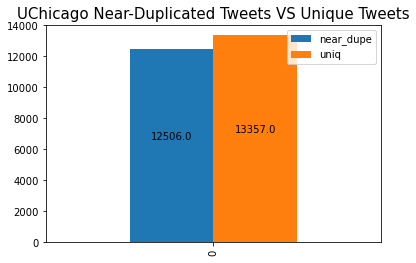

In [ ]:
ax=dic1.plot(kind = 'bar', fontsize=10)
ax.set_title('UChicago Near-Duplicated Tweets VS Unique Tweets', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 


### Now, let's compare different threshold result.
### Self join in Approximate similarity and set 0.3 as near duplicate threshold.

In [ ]:
l2=model.approxSimilarityJoin(transa, transa, 0.3).filter("datasetA.id < datasetB.id").select(col("datasetA.id").alias("idA"), 
                                                                                             col("datasetB.id").alias("idB"), 
                                                                                             col("distCol"))

In [ ]:
g2=l2.groupBy("idA").count().toPandas()
g2.head()

,idA,count
0,77488,109
1,358184,22
2,74138,99
3,125171,88
4,169522,376


In [ ]:
dupe=len(g2.idA)
uniq=dfA.count()-dupe

In [ ]:
df_uchi2 = l2.toPandas()

In [ ]:
df_uchi2['dupe_idx2']= list(zip(df_uchi2.idA, df_uchi2.idB))

In [54]:
new = df_uchi2.drop(['distCol'], axis=1)
new.to_csv('gs://msca-bigdata-1/notebooks/gchai/df_uchi2.csv', index = False)

In [ ]:
dic=pd.DataFrame.from_dict({'near_dupe': [dupe], 'uniq': [uniq]})
dic  

,near_dupe,uniq
0,11944,13919


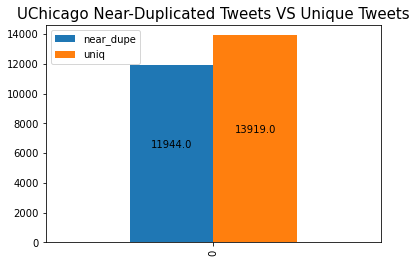

In [ ]:
ax=dic.plot(kind = 'bar', fontsize=10)
ax.set_title('UChicago Near-Duplicated Tweets VS Unique Tweets', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### Self join in Approximate similarity and set 0.6 as near duplicate threshold.

In [ ]:
l3=model.approxSimilarityJoin(transa, transa, 0.6).filter("datasetA.id < datasetB.id").select(col("datasetA.id").alias("idA"), 
                                                                                             col("datasetB.id").alias("idB"), 
                                                                                             col("distCol"))

In [ ]:
g3=l3.groupBy("idA").count().toPandas()
g3.head()

,idA,count
0,186686,354
1,95284,476
2,141445,436
3,74138,99
4,125171,88


In [ ]:
dupe=len(g3.idA)
uniq=dfA.count()-dupe

In [ ]:
dic=pd.DataFrame.from_dict({'near_dupe': [dupe], 'uniq': [uniq]})
dic

,near_dupe,uniq
0,13840,12023


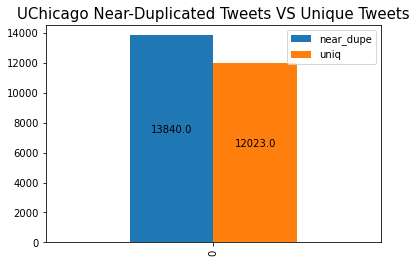

In [ ]:
ax=dic.plot(kind = 'bar', fontsize=10)
ax.set_title('UChicago Near-Duplicated Tweets VS Unique Tweets', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [ ]:
df_uchi3 = l3.toPandas()
df_uchi3['dupe_idx3']=list(zip(df_uchi3.idA, df_uchi3.idB))
new = df_uchi3.drop(['distCol'], axis=1)
new.to_csv('gs://msca-bigdata-1/notebooks/gchai/df_uchi3.csv', index = False)


## Now, let's prepare a table that include 100 pairs and compare their dup/non-dup results from the 3 thresholds 

1. 0.3 threshold has the least dupe pairs since 0.3 distance means a 0.7 Jaccard similarity, and thus 0.6 has the most dupe pairs .

2. Assume I have 25,000 data, either threshold generates (2,5000 X 2,5000)/2 unique pairs --(tweetA and tweetC) is the same as (tweetC and tweetA). This means I have more than 312 million pairs. If the 0.3 threshold generates 1 million dupe pairs, then 0.5 threshold could make 1.5 million dupe pairs, and 0.6 threshold could make 2 million dupe pairs. If I randomly select 100 pairs from either threshold result, it high likely will be all Non-dupe/ or all dupe in all three-threshold result, so the example table doesn't show comparison purpose at all.

3. To make a comparison and to see different result, I first select 50 pairs from 0.3 threshold result (these pairs will be dupe for all three thresholds). Then I find dupe pairs that recognized from 0.5 not 0.3, and take 25 pairs sample from the difference. These 25 will be non-dupe for 0.3 threshold and dupe for 0.5 threshold. Lastly, I find dupe pairs that recognized by 0.6 threshold and not by 0.5, take 25 pairs sample from it.

In [67]:
# check how many dupe pairs in each threshold
print('amount of dupe pairs by 0.5 threshold:',len(df_uchi1.dupe_idx1))
print('amount of dupe pairs by 0.3 threshold:',len(df_uchi2.dupe_idx2))
print('amount of dupe pairs by 0.6 threshold:',len(df_uchi3.dupe_idx3))

amount of dupe pairs by 0.5 threshold: 546975
amount of dupe pairs by 0.3 threshold: 532953
amount of dupe pairs by 0.6 threshold: 637772


In [8]:
# 0.3 threshold has the least dupe pairs, first find dupe pairs that recognized in 0.5 threshold, not 0.3
z = list(set(df_uchi1.dupe_idx1) - set(df_uchi2.dupe_idx2))
len(z)

14022

In [9]:
#find dupe pairs that recognized in 0.6, not in 0.5
zz =list(set(df_uchi3.dupe_idx3) - set(df_uchi1.dupe_idx1))
len(zz)

90797

In [10]:
uchi=uchi.toPandas()
uchi.head()

,text,id
0,"(Non-UChicago people ignore this tweet...,)",0
1,"(the four uchicago dress senses: business casual (25%), unrepentant STEMlord (20%), gay ascetic (10%), seinfeld extra (45%),)",1
2,"(Professor Bruce Cumings @bruce4korea from University of Chicago and the author of 'The Origins of the Korean War' joins us.,)",2
3,"(RT @HdxAcademy: We congratulate @UChicago &amp; Pres R. Zimmer on their top rating in our Guide to Colleges: Top 150 Universities:… ,)",3
4,"(Great visit from @UChicago students #PaulSereno lab! Exhibits, #histology #anagensis #dinosaurs! FUN w/… https://t.co/byatkv4uth,)",4


In [11]:
# sample 50 pairs from 0.3 threshold result
ex_uchi1 = df_uchi2.sample(50, random_state=1).drop(['dupe_idx2'],axis=1)

#sample 25 from pairs that recognized by 0.5 not 0.3
ex_uchi2 = df_uchi1[df_uchi1['dupe_idx1'].isin(z)].sample(25, random_state=1).drop(['dupe_idx1'],axis=1)

#sample 25 from pairs that recognized by 0.6 not 0.5
ex_uchi3 = df_uchi3[df_uchi3['dupe_idx3'].isin(zz)].sample(25, random_state=1).drop(['dupe_idx3'], axis=1)


In [12]:
table=pd.concat([ex_uchi1, ex_uchi2, ex_uchi3], axis=0)

In [19]:
pd.set_option('display.max_rows', None)
table['text1'] = [uchi.loc[uchi.id==i, "text"].values for i in list(table.idA)] 
table['text2'] = [uchi.loc[uchi.id==i, "text"].values for i in list(table.idB)] 
table['0.3threshold'] = ['Dupe']*50 + ['Non-Dupe']*50
table['0.5threshold'] = ['Dupe']*75 + ['Non-Dupe']*25
table['0.6threshold'] = ['Dupe']*100
table=table.reset_index(drop=True)
table

,idA,idB,text1,text2,0.3threshold,0.5threshold,0.6threshold
0,80407,556921,"[(RT @sambjoyce: uchicago is currently hiring for a *part-time* position that requires you to relocate to the south pole https://t.co/9h71yzP…,)]","[(RT @sambjoyce: uchicago is currently hiring for a *part-time* position that requires you to relocate to the south pole https://t.co/9h71yzP…,)]",Dupe,Dupe,Dupe
1,525827,553287,"[(RT @NobelPrize: BREAKING NEWS The 2017 Prize in Economic Sciences is awarded to Richard H. Thaler @R_Thaler @UChicago @ChicagoBooth… ,)]","[(RT @NobelPrize: BREAKING NEWS The 2017 Prize in Economic Sciences is awarded to Richard H. Thaler @R_Thaler @UChicago @ChicagoBooth… ,)]",Dupe,Dupe,Dupe
2,353753,398933,"[(RT @sambjoyce: uchicago is currently hiring for a *part-time* position that requires you to relocate to the south pole https://t.co/9h71yzP…,)]","[(RT @sambjoyce: uchicago is currently hiring for a *part-time* position that requires you to relocate to the south pole https://t.co/9h71yzP…,)]",Dupe,Dupe,Dupe
3,108108,146320,"[(RT @ChuckModi1: University of Chicago dropping SAT is huge win against classism. Then THIS!:,)]","[(RT @ChuckModi1: University of Chicago dropping SAT is huge win against classism. Then THIS!:,)]",Dupe,Dupe,Dupe
4,394633,456872,"[(RT @ChuckModi1: University of Chicago dropping SAT is huge win against classism. Then THIS!:,)]","[(RT @ChuckModi1: University of Chicago dropping SAT is huge win against classism. Then THIS!:,)]",Dupe,Dupe,Dupe
5,252885,358798,"[(RT @Mimirocah1: University of Chicago Law classmates tell Trump lawyer Cipollone he distorts Constitution by blocking impeachment witnesses…,)]","[(RT @Mimirocah1: University of Chicago Law classmates tell Trump lawyer Cipollone he distorts Constitution by blocking impeachment witnesses…,)]",Dupe,Dupe,Dupe
6,220345,414326,"[(RT @finessence_: when them uchicago students walk a lil too far south https://t.co/QWCj4SqwxP,)]","[(RT @finessence_: when them uchicago students walk a lil too far south https://t.co/QWCj4SqwxP,)]",Dupe,Dupe,Dupe
7,263166,285866,"[(RT @finessence_: when them uchicago students walk a lil too far south https://t.co/QWCj4SqwxP,)]","[(RT @finessence_: when them uchicago students walk a lil too far south https://t.co/QWCj4SqwxP,)]",Dupe,Dupe,Dupe
8,308333,535526,"[(RT @ChuckModi1: University of Chicago dropping SAT is huge win against classism. Then THIS!:,)]","[(RT @ChuckModi1: University of Chicago dropping SAT is huge win against classism. Then THIS!:,)]",Dupe,Dupe,Dupe
9,8408,384579,"[(RT @ChuckModi1: University of Chicago dropping SAT is huge win against classism. Then THIS!:,)]","[(RT @ChuckModi1: University of Chicago dropping SAT is huge win against classism. Then THIS!:,)]",Dupe,Dupe,Dupe


In [18]:
table.to_csv('gs://msca-bigdata-1/notebooks/gchai/uchi_table.csv', index = False)

# Summary:
Based on the 100 samples from the three different threshold, I will recommend to choose 0.5 as the threshold. The 25 pairs showed by 0.5 are pretty much near-duplicates. However, there are some pairs in the 0.6 result doesn't seem to relate each other. For example: 

"The University of Chicago is the world's number 9 university! #QSWUR https://t.co/PrOjcV6V4a"

'University of Chicago Scholarships 2018 (Full Ride) https://t.co/iGml4brESa https://t.co/MihhL2dECH'

In order to have more accurate result. I recommend to choose 0.5 threshold for UChicago tweets Unique VS Near-dupe analysis. 

# UNL

In [21]:
unl_text = df_unl.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")
unl_tokens = unl_text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalpha()])\
    .map( lambda word: [x for x in word if len(x) > 3])\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

In [22]:
unl_txts = sqlContext.createDataFrame(unl_tokens, ["list_of_words",'id'])
result2=unl_txts.select("list_of_words",'id')
result2.show()

+--------------------+---+
|       list_of_words| id|
+--------------------+---+
|        [university]|  0|
|        [university]|  1|
|        [university]|  2|
|        [university]|  3|
|[gems, great, tim...|  4|
|[performance, how...|  5|
|        [university]|  6|
|        [university]|  7|
|        [university]|  8|
|[excited, announc...|  9|
|        [university]| 10|
|        [university]| 11|
|        [university]| 12|
|[university, nebr...| 13|
|        [university]| 14|
|        [university]| 15|
|        [university]| 16|
|        [university]| 17|
|[excited, announc...| 18|
|        [university]| 19|
+--------------------+---+
only showing top 20 rows



In [23]:
row = Row("text") 
unl=unl_text.map(row).zipWithIndex().toDF(['text','id'])
unl.show(5)

+--------------------+---+
|                text| id|
+--------------------+---+
|[RT @_TheJoshuaMo...|  0|
|[RT @_TheJoshuaMo...|  1|
|[RT @_TheJoshuaMo...|  2|
|[RT @_TheJoshuaMo...|  3|
|[RT @IdahoBoiseGe...|  4|
+--------------------+---+
only showing top 5 rows



In [79]:
result2.count()

195613

In [82]:
dff2=result2.filter(size("list_of_words") >= 3)
dff2.count()

185049

### Chose sample for minhashLSH analysis

In [91]:
df_unlA=dff2.sample(False,0.05,0)#.rdd.map(lambda x: x['list_of_words']).zipWithIndex()
#df_unlA=sqlContext.createDataFrame(df_unlA, ["list_of_words",'id'])
df_unlA.show()

+--------------------+---+
|       list_of_words| id|
+--------------------+---+
|[extremely, bless...| 25|
|[lyft, costs, cre...| 85|
|[love, university...|131|
|[university, nebr...|157|
|[university, nebr...|179|
|[university, nebr...|203|
|[university, nebr...|235|
|[university, nebr...|242|
|[university, nebr...|270|
|[university, nebr...|278|
|[university, nebr...|290|
|[university, nebr...|316|
|[excited, receive...|320|
|[university, nebr...|335|
|[university, nebr...|367|
|[university, nebr...|380|
|[university, nebr...|393|
|[university, nebr...|426|
|[support, appoint...|475|
|[beyond, excited,...|488|
+--------------------+---+
only showing top 20 rows



### Fit in countvectorizer to create features

In [84]:
unl_cv = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_unlA1 = unl_cv.fit(df_unlA)
df_unlA2 = df_unlA1.transform(df_unlA)
df_unlA2.show(5)

+--------------------+---+--------------------+
|       list_of_words| id|            features|
+--------------------+---+--------------------+
|[extremely, bless...| 25|(4217,[0,1,3,7,10...|
|[lyft, costs, cre...| 85|(4217,[0,1,20,27,...|
|[love, university...|131|(4217,[0,1,55,106...|
|[university, nebr...|157|(4217,[0,1,29,70,...|
|[university, nebr...|179|(4217,[0,1,29,70,...|
+--------------------+---+--------------------+
only showing top 5 rows



### Fit in MinHashLSH to create hash table

In [85]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model2 = mh.fit(df_unlA2)
transa2=model2.transform(df_unlA2)
transa2.show(5)

+--------------------+---+--------------------+--------------------+
|       list_of_words| id|            features|              hashes|
+--------------------+---+--------------------+--------------------+
|[extremely, bless...| 25|(4217,[0,1,3,7,10...|[[4.7945584E7], [...|
|[lyft, costs, cre...| 85|(4217,[0,1,20,27,...|[[3.331227E7], [1...|
|[love, university...|131|(4217,[0,1,55,106...|[[4.7945584E7], [...|
|[university, nebr...|157|(4217,[0,1,29,70,...|[[4.7945584E7], [...|
|[university, nebr...|179|(4217,[0,1,29,70,...|[[4.7945584E7], [...|
+--------------------+---+--------------------+--------------------+
only showing top 5 rows



### Self join in Approximate similarity and set 0.5 as near duplicate threshold. The table will return pairs that has jaccard distance less than 0.5

In [86]:
l4=model2.approxSimilarityJoin(transa2, transa2, 0.5).filter("datasetA.id < datasetB.id").select(col("datasetA.id").alias("idA"),
            col("datasetB.id").alias("idB"),
            col("distCol"))


In [87]:
g4=l4.groupBy("idA").count().toPandas()
g4.head()

,idA,count
0,141756,129
1,158982,40
2,55845,20
3,15173,2180
4,44134,1858


In [89]:
dupe=len(g4.idA)
uniq=df_unlA.count()-dupe
dic2=pd.DataFrame.from_dict({'near_dupe': [dupe], 'uniq': [uniq]})
dic2  

,near_dupe,uniq
0,7115,2138


### Visualize Near-Dupe VS Unique

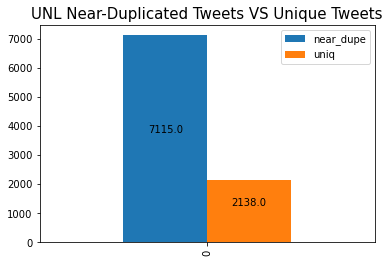

In [90]:
ax=dic2.plot(kind = 'bar', fontsize=10)
ax.set_title('UNL Near-Duplicated Tweets VS Unique Tweets', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [92]:
df_unl1 = l4.toPandas()
df_unl1['dupe_idx1']=list(zip(df_unl1.idA, df_unl1.idB))
new = df_unl1.drop(['distCol'], axis=1)
new.to_csv('gs://msca-bigdata-1/notebooks/gchai/df_unl1.csv', index = False)


### Self join in Approximate similarity and set 0.3 as near duplicate threshold.

In [93]:
l5=model2.approxSimilarityJoin(transa2, transa2, 0.3).filter("datasetA.id < datasetB.id").select(col("datasetA.id").alias("idA"),
            col("datasetB.id").alias("idB"),
            col("distCol"))

In [ ]:
g5=l5.groupBy("idA").count().toPandas()
g5.head()

,idA,count
0,15173,1426
1,32571,461
2,37521,70
3,44134,1203
4,49754,1153


In [ ]:
dupe=len(g5.idA)
uniq=df_unlA.count()-dupe
dic2=pd.DataFrame.from_dict({'near_dupe': [dupe], 'uniq': [uniq]})
dic2  

,near_dupe,uniq
0,6729,2524


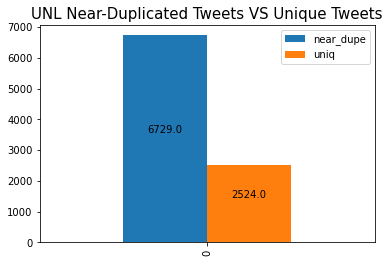

In [ ]:
ax=dic2.plot(kind = 'bar', fontsize=10)
ax.set_title('UNL Near-Duplicated Tweets VS Unique Tweets', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [ ]:
df_unl2 = l5.toPandas()
df_unl2['dupe_idx2']=list(zip(df_unl2.idA, df_unl2.idB))
new = df_unl2.drop(['distCol'], axis=1)
new.to_csv('gs://msca-bigdata-1/notebooks/gchai/df_unl2.csv', index = False)

### Self join in Approximate similarity and set 0.6 as near duplicate threshold.

In [ ]:
l6=model2.approxSimilarityJoin(transa2, transa2, 0.6).filter("datasetA.id < datasetB.id").select(col("datasetA.id").alias("idA"),
            col("datasetB.id").alias("idB"),
            col("distCol"))

In [ ]:
g6=l6.groupBy("idA").count().toPandas()
g6.head()

,idA,count
0,118448,889
1,15173,2948
2,32571,2312
3,44134,2184
4,49754,2092


In [ ]:
dupe=len(g6.idA)
uniq=df_unlA.count()-dupe
dic2=pd.DataFrame.from_dict({'near_dupe': [dupe], 'uniq': [uniq]})
dic2 

,near_dupe,uniq
0,7575,1678


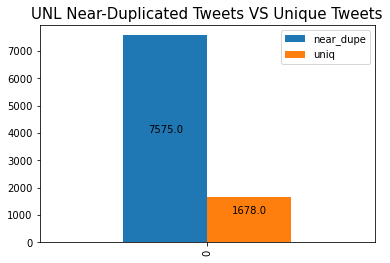

In [ ]:
ax=dic2.plot(kind = 'bar', fontsize=10)
ax.set_title('UNL Near-Duplicated Tweets VS Unique Tweets', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [ ]:
df_unl3 = l6.toPandas()
df_unl3['dupe_idx3']=list(zip(df_unl3.idA, df_unl3.idB))
new = df_unl3.drop(['distCol'], axis=1)
new.to_csv('gs://msca-bigdata-1/notebooks/gchai/df_unl3.csv', index = False)

## Now, let's prepare a table that include 100 pairs and compare their dup/non-dup results from the 3 thresholds 

In [23]:
# check how many dupe pairs in each threshold
print('amount of dupe pairs by 0.5 threshold:',len(df_unl1.dupe_idx1))
print('amount of dupe pairs by 0.3 threshold:',len(df_unl2.dupe_idx2))
print('amount of dupe pairs by 0.6 threshold:',len(df_unl3.dupe_idx3))
print('diff dupe pairs between 0.5 and 0.3:',len(df_unl1.dupe_idx1)-len(df_unl2.dupe_idx2))
print('diff dupe pairs between 0.6 and 0.5:',len(df_unl3.dupe_idx3)-len(df_unl1.dupe_idx1))

amount of dupe pairs by 0.5 threshold: 2798968
amount of dupe pairs by 0.3 threshold: 1347420
amount of dupe pairs by 0.6 threshold: 4971078
diff dupe pairs between 0.5 and 0.3: 1451548
diff dupe pairs between 0.6 and 0.5: 2172110


In [24]:
# 0.3 threshold has the least dupe pairs, first find dupe pairs that recognized in 0.5 threshold, not 0.3
z = list(set(df_unl1.dupe_idx1) - set(df_unl2.dupe_idx2))
len(z)

1458426

In [25]:
#find dupe pairs that recognized in 0.6, not in 0.5
zz =list(set(df_unl3.dupe_idx3) - set(df_unl1.dupe_idx1))
len(zz)

2174364

In [26]:
unl=unl.toPandas()
# sample 50 pairs from 0.3 threshold result
ex_unl1 = df_unl2.sample(50, random_state=1).drop(['dupe_idx2'],axis=1)

#sample 25 from pairs that recognized by 0.5 not 0.3
ex_unl2 = df_unl1[df_unl1['dupe_idx1'].isin(z)].sample(25, random_state=1).drop(['dupe_idx1'],axis=1)

#sample 25 from pairs that recognized by 0.6 not 0.5
ex_unl3 = df_unl3[df_unl3['dupe_idx3'].isin(zz)].sample(25, random_state=1).drop(['dupe_idx3'], axis=1)

table2=pd.concat([ex_unl1, ex_unl2, ex_unl3], axis=0)

In [27]:
table2['text1'] = [unl.loc[unl.id==i, "text"].values for i in list(table2.idA)] 
table2['text2'] = [unl.loc[unl.id==i, "text"].values for i in list(table2.idB)] 
table2['0.3threshold'] = ['Dupe']*50 + ['Non-Dupe']*50
table2['0.5threshold'] = ['Dupe']*75 + ['Non-Dupe']*25
table2['0.6threshold'] = ['Dupe']*100
table2=table2.reset_index(drop=True)
table2

,idA,idB,text1,text2,0.3threshold,0.5threshold,0.6threshold
0,44218,60090,"[(RT @PlumleeJohn: Blessed to receive an offer from the University of Nebraska‼️‼️ @Coach_Verdu @DemetricDWarren @QBCountry https://t.co/H…,)]","[(RT @DT_26x: Blessed to receive an offer from the University of Nebraska @HuskerFBNation @OHSKnightsFB @CS2SA @ProImpactJax7v7 @247Sports @R…,)]",Dupe,Dupe,Dupe
1,91808,138185,"[(RT @puuupppp: Extremely blessed to receive a offer from the University of Nebraska #GBR We making it out pops❤️💯 @elodge4 @speedline04 @Coa…,)]","[(RT @dazalin4: Blessed to receive an offer from The University of Nebraska ! 🌽 #GBR https://t.co/hUuHt4cnWA,)]",Dupe,Dupe,Dupe
2,56630,104190,"[(RT @Ballhawk_Twan: Blessed to receive an offer from the University of Nebraska #Cornhuskers #B1G @CoachTFisher @Andrew_Ivins @CoachVerne @…,)]","[(RT @ConstantLamy20: Blessed to receive an Offer from The University of Nebraska-Lincoln!! #GBR 🌽🏈 #GoCornhuskers https://t.co/nK4ZMiQFU9,)]",Dupe,Dupe,Dupe
3,114019,180510,"[(RT @CeaserNelson: Blessed to receive an offer from The University of Nebraska #GOBIGRED 🔴⚪️ https://t.co/4oyXOCCT4k,)]","[(RT @Qnew_2019: Blessed to receive an offer from The University of Nebraska!!! #GBR 🌽 https://t.co/6loZtVafXy,)]",Dupe,Dupe,Dupe
4,48759,79279,"[(RT @brieon40: Blessed to receive an offer from University Of Nebraska🙏💯 #Huskers https://t.co/dVO1Sc2frm,)]","[(RT @ZaneHerring51: Blessed to Receive an Offer from THE University of Nebraska 🌽‼️ @coach_frost @SeanDillonNU https://t.co/A0DjsRggsw,)]",Dupe,Dupe,Dupe
5,24453,114019,"[(RT @Te_Smith26: Blessed to receive an offer from University of Nebraska #GBR 🌽 https://t.co/PlzgfU3hZ8,)]","[(RT @CeaserNelson: Blessed to receive an offer from The University of Nebraska #GOBIGRED 🔴⚪️ https://t.co/4oyXOCCT4k,)]",Dupe,Dupe,Dupe
6,68880,130050,"[(RT @FordCourtland: Blessed to say i have received an offer from the University Of Nebraska #GBR 🌽🔴⚪️ @CoachRHeld @Kickslide https://t.co/G3…,)]","[(RT @JamesCarnie1: Blessed to have received an offer from the University of Nebraska! #GBR https://t.co/K1duru5j7b,)]",Dupe,Dupe,Dupe
7,41494,182999,"[(Blessed to receive an offer from The University of Nebraska! #GBR @coachdawsgbr @EdOBrien247 @Preps247Sports… https://t.co/WYCracbf8i,)]","[(RT @rosemy_marcus: Blessed To Receive A(n) Offer From The University Of Nebraska 🙏🏾 https://t.co/qWf8kbTMQd,)]",Dupe,Dupe,Dupe
8,155328,158000,"[(RT @ChoeBryant: Extremely blessed to receive an offer from the University of Nebraska ‼️ @CoachBeckton #GoHuskers https://t.co/SXuXtcvYXm,)]","[(RT @_JuliusCoates3: Very blessed to receive an offer from The University of Nebraska !! ☠️ #GBR https://t.co/b5E6lIXRbj,)]",Dupe,Dupe,Dupe
9,40625,102081,"[(RT @grantis_p: Extremely blessed to receive an offer from The University of Nebraska #Cornhuskers 🌽🔴⚪️@Dameon8 @SleeperAthletes @Rivalsfbc…,)]","[(RT @_JalenSt75: Extremely blessed and honored to receive an offer from the University of Nebraska!! 🌽🔴,)]",Dupe,Dupe,Dupe


In [44]:
table2.to_csv('gs://msca-bigdata-1/notebooks/gchai/unl_table.csv', index = False)

# Summary:

For UNL, I also recommend to choose 0.6 as threshold. Seems like most of the UNL tweets are related offers since all the samples are talking about offers. By looking at the 0.6 threshold pairs, I don't see any difference between the tweets. Most of them tagged more people, so the name caused difference. However, the contents are still same. Thus, 0.6 threshold for UNL is recommended


# Northeastern

In [28]:
north_text = df_north.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)
north_tokens = north_text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalpha()])\
    .map( lambda word: [x for x in word if len(x) > 3])\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

In [35]:
row = Row("text") 
north=north_text.map(row).zipWithIndex().toDF(['text','id'])
north.show(5)

+--------------------+---+
|                text| id|
+--------------------+---+
|[Good evening Nor...|  0|
|[Super excited to...|  1|
|[location of nort...|  2|
|[It's windy at No...|  3|
|[northeastern uni...|  4|
+--------------------+---+
only showing top 5 rows



In [47]:
north_txts = sqlContext.createDataFrame(north_tokens, ["list_of_words",'id'])
result3=north_txts.select("list_of_words",'id')
result3.show()

+--------------------+---+
|       list_of_words| id|
+--------------------+---+
|[good, evening, n...|  0|
|[super, excited, ...|  1|
|[location, northe...|  2|
|[windy, northeast...|  3|
|[northeastern, un...|  4|
|[northeastern, un...|  5|
|[updated, eclipse...|  6|
|[northeastern, un...|  7|
|[former, northeas...|  8|
|[former, northeas...|  9|
|[former, northeas...| 10|
|[former, northeas...| 11|
|[former, northeas...| 12|
|[former, northeas...| 13|
|[former, northeas...| 14|
|[former, northeas...| 15|
|[former, northeas...| 16|
|[former, northeas...| 17|
|[former, northeas...| 18|
|[former, northeas...| 19|
+--------------------+---+
only showing top 20 rows



In [125]:
result3.count()

87411

In [48]:
dff3=result3.filter(size("list_of_words") >= 3)
dff3.count()

82640

### Chose sample for minhashLSH analysis

In [49]:
df_northA=dff3.sample(False,0.05,0)#.rdd.map(lambda x: x['list_of_words']).zipWithIndex()
#df_northA=sqlContext.createDataFrame(df_northA, ["list_of_words",'id'])
df_northA.show()

+--------------------+---+
|       list_of_words| id|
+--------------------+---+
|[former, northeas...| 10|
|[former, northeas...| 27|
|[former, northeas...| 67|
|[former, northeas...| 93|
|[former, northeas...|115|
|[former, northeas...|140|
|[good, evening, n...|172|
|[proud, announce,...|179|
|[northeastern, un...|207|
|[time, make, nort...|215|
|[northeastern, un...|227|
|[northeastern, un...|255|
|[northeastern, un...|259|
|[congratulations,...|274|
|[josé, buscaglia,...|307|
|[northeastern, un...|320|
|[comments, soiled...|334|
|[answer, clue, no...|366|
|[northeastern, un...|418|
|[northeastern, un...|432|
+--------------------+---+
only showing top 20 rows



### Fit in countvectorizer to create features

In [50]:
north_cv = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_northA1 = north_cv.fit(df_northA)
df_northA2 = df_northA1.transform(df_northA)
df_northA2.show(5)

+--------------------+---+--------------------+
|       list_of_words| id|            features|
+--------------------+---+--------------------+
|[former, northeas...| 10|(2892,[0,1,16,66,...|
|[former, northeas...| 27|(2892,[0,1,16,66,...|
|[former, northeas...| 67|(2892,[0,1,16,66,...|
|[former, northeas...| 93|(2892,[0,1,16,66,...|
|[former, northeas...|115|(2892,[0,1,16,66,...|
+--------------------+---+--------------------+
only showing top 5 rows



### Fit in MinHashLSH to create hash table

In [59]:
model3 = mh.fit(df_northA2)
transa3=model3.transform(df_northA2)
transa3.show(5)

+--------------------+---+--------------------+--------------------+
|       list_of_words| id|            features|              hashes|
+--------------------+---+--------------------+--------------------+
|[former, northeas...| 10|(2892,[0,1,16,66,...|[[4.7945584E7], [...|
|[former, northeas...| 27|(2892,[0,1,16,66,...|[[4.7945584E7], [...|
|[former, northeas...| 67|(2892,[0,1,16,66,...|[[4.7945584E7], [...|
|[former, northeas...| 93|(2892,[0,1,16,66,...|[[4.7945584E7], [...|
|[former, northeas...|115|(2892,[0,1,16,66,...|[[4.7945584E7], [...|
+--------------------+---+--------------------+--------------------+
only showing top 5 rows



### Self join in Approximate similarity and set 0.5 as near duplicate threshold. The table will return pairs that has jaccard distance less than 0.5

In [60]:
l7=model3.approxSimilarityJoin(transa3, transa3, 0.5).filter("datasetA.id < datasetB.id").select(col("datasetA.id").alias("idA"),
            col("datasetB.id").alias("idB"),
            col("distCol"))

### Visualize Near-Dupe VS Unique

In [61]:
g7=l7.groupBy("idA").count().toPandas()
g7.head()

,idA,count
0,23766,301
1,37261,79
2,79666,4
3,39627,39
4,54039,53


In [62]:
dupe=len(g7.idA)
uniq=df_northA.count()-dupe
dic3=pd.DataFrame.from_dict({'near_dupe': [dupe], 'uniq': [uniq]})
dic3 

,near_dupe,uniq
0,2860,1187


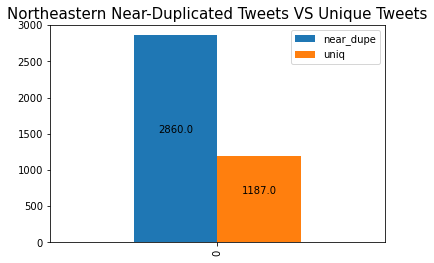

In [63]:
ax=dic3.plot(kind = 'bar', fontsize=10)
ax.set_title('Northeastern Near-Duplicated Tweets VS Unique Tweets', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [64]:
df_north1 = l7.toPandas()
df_north1['dupe_idx1']=list(zip(df_north1.idA, df_north1.idB))
new = df_north1.drop(['distCol'], axis=1)
new.to_csv('gs://msca-bigdata-1/notebooks/gchai/df_north1.csv', index = False)

### Self join in Approximate similarity and set 0.3 as near duplicate threshold.

In [65]:
l8=model3.approxSimilarityJoin(transa3, transa3, 0.3).filter("datasetA.id < datasetB.id").select(col("datasetA.id").alias("idA"),
            col("datasetB.id").alias("idB"),
            col("distCol"))

In [ ]:
g8=l8.groupBy("idA").count().toPandas()
g8.head()

,idA,count
0,23766,301
1,78671,21
2,37261,79
3,54039,53
4,77180,21


In [ ]:
dupe=len(g8.idA)
uniq=df_northA.count()-dupe
dic3=pd.DataFrame.from_dict({'near_dupe': [dupe], 'uniq': [uniq]})
dic3 

,near_dupe,uniq
0,2736,1311


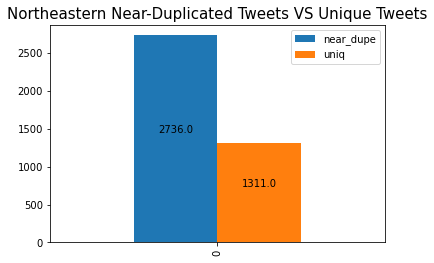

In [ ]:
ax=dic3.plot(kind = 'bar', fontsize=10)
ax.set_title('Northeastern Near-Duplicated Tweets VS Unique Tweets', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [ ]:
df_north2 = l8.toPandas()
df_north2['dupe_idx2']=list(zip(df_north2.idA, df_north2.idB))
new = df_north2.drop(['distCol'], axis=1)
new.to_csv('gs://msca-bigdata-1/notebooks/gchai/df_north2.csv', index = False)

### Self join in Approximate similarity and set 0.6 as near duplicate threshold.

In [ ]:
l9=model3.approxSimilarityJoin(transa3, transa3, 0.6).filter("datasetA.id < datasetB.id").select(col("datasetA.id").alias("idA"),
            col("datasetB.id").alias("idB"),
            col("distCol"))

In [ ]:
g9=l9.groupBy("idA").count().toPandas()
g9.head()

,idA,count
0,23766,301
1,39627,90
2,37261,79
3,54039,53
4,78365,55


In [ ]:
dupe=len(g9.idA)
uniq=df_northA.count()-dupe
dic3=pd.DataFrame.from_dict({'near_dupe': [dupe], 'uniq': [uniq]})
dic3 

,near_dupe,uniq
0,3082,965


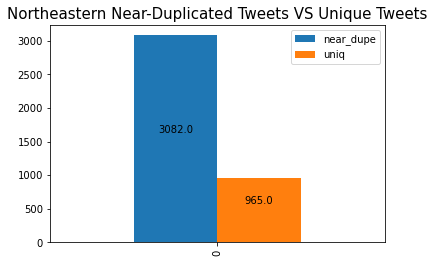

In [ ]:
ax=dic3.plot(kind = 'bar', fontsize=10)
ax.set_title('Northeastern Near-Duplicated Tweets VS Unique Tweets', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [ ]:
df_north3 = l9.toPandas()
df_north3['dupe_idx3']=list(zip(df_north3.idA, df_north3.idB))
new = df_north3.drop(['distCol'], axis=1)
new.to_csv('gs://msca-bigdata-1/notebooks/gchai/df_north3.csv', index = False)

In [ ]:
# check how many dupe pairs in each threshold
print('amount of dupe pairs by 0.5 threshold:',len(df_north1.dupe_idx1))
print('amount of dupe pairs by 0.3 threshold:',len(df_north2.dupe_idx2))
print('amount of dupe pairs by 0.6 threshold:',len(df_north3.dupe_idx3))
print('diff dupe pairs between 0.5 and 0.3:',len(df_north1.dupe_idx1)-len(df_north2.dupe_idx2))
print('diff dupe pairs between 0.6 and 0.5:',len(df_north3.dupe_idx3)-len(df_north1.dupe_idx1))

amount of dupe pairs by 0.5 threshold: 316550
amount of dupe pairs by 0.3 threshold: 310797
amount of dupe pairs by 0.6 threshold: 353476
diff dupe pairs between 0.5 and 0.3: 5753
diff dupe pairs between 0.6 and 0.5: 36926


In [31]:
# 0.3 threshold has the least dupe pairs, first find dupe pairs that recognized in 0.5 threshold, not 0.3
z = list(set(df_north1.dupe_idx1) - set(df_north2.dupe_idx2))
len(z)

5753

In [32]:
#find dupe pairs that recognized in 0.6, not in 0.5
zz =list(set(df_north3.dupe_idx3) - set(df_north1.dupe_idx1))
len(zz)

36926

In [36]:
north=north.toPandas()
# sample 50 pairs from 0.3 threshold result
ex_north1 = df_north2.sample(50, random_state=1).drop(['dupe_idx2'],axis=1)

#sample 25 from pairs that recognized by 0.5 not 0.3
ex_north2 = df_north1[df_north1['dupe_idx1'].isin(z)].sample(25, random_state=1).drop(['dupe_idx1'],axis=1)

#sample 25 from pairs that recognized by 0.6 not 0.5
ex_north3 = df_north3[df_north3['dupe_idx3'].isin(zz)].sample(25, random_state=1).drop(['dupe_idx3'], axis=1)

table3=pd.concat([ex_north1, ex_north2, ex_north3], axis=0)

In [37]:
table3['text1'] = [north.loc[north.id==i, "text"].values for i in list(table3.idA)] 
table3['text2'] = [north.loc[north.id==i, "text"].values for i in list(table3.idB)] 
table3['0.3threshold'] = ['Dupe']*50 + ['Non-Dupe']*50
table3['0.5threshold'] = ['Dupe']*75 + ['Non-Dupe']*25
table3['0.6threshold'] = ['Dupe']*100
table3=table3.reset_index(drop=True)
table3

,idA,idB,text1,text2,0.3threshold,0.5threshold,0.6threshold
0,21042,71626,"[(RT @Northeastern: We want to reassure students who have applied or have been admitted to Northeastern University that disciplinary actions…,)]","[(RT @Northeastern: We want to reassure students who have applied or have been admitted to Northeastern University that disciplinary actions…,)]",Dupe,Dupe,Dupe
1,8694,77703,"[(RT @BostonGlobe: Northeastern University has dismissed 11 first-year students after they were caught violating social distancing rules, the…,)]","[(RT @BostonGlobe: Northeastern University has dismissed 11 first-year students after they were caught violating social distancing rules, the…,)]",Dupe,Dupe,Dupe
2,10830,11326,"[(RT @ChuckCallesto: BREAKING REPORT: Northeastern University has dismissed 11 first-year students after they were caught VIOLATING SOCIAL DI…,)]","[(RT @BostonGlobe: Northeastern University has dismissed 11 first-year students after they were caught violating social distancing rules, the…,)]",Dupe,Dupe,Dupe
3,10160,74457,"[(RT @BostonGlobe: Northeastern University has dismissed 11 first-year students after they were caught violating social distancing rules, the…,)]","[(RT @BostonGlobe: Northeastern University has dismissed 11 first-year students after they were caught violating social distancing rules, the…,)]",Dupe,Dupe,Dupe
4,58162,83834,"[(""RT @denial101x: """"This just happened"""" Associate professor Jennifer Bowen at Northeastern University,)]","[(""RT @denial101x: """"This just happened"""" Associate professor Jennifer Bowen at Northeastern University,)]",Dupe,Dupe,Dupe
5,10127,24260,"[(RT @BostonGlobe: Northeastern University has dismissed 11 first-year students after they were caught violating social distancing rules, the…,)]","[(RT @BostonGlobe: Northeastern University has dismissed 11 first-year students after they were caught violating social distancing rules, the…,)]",Dupe,Dupe,Dupe
6,12628,84436,"[(RT @eric_clapp: The buried lede is that Northeastern University didn’t want to miss out on $73,000/year/person (!) by going online, so they…,)]","[(RT @eric_clapp: The buried lede is that Northeastern University didn’t want to miss out on $73,000/year/person (!) by going online, so they…,)]",Dupe,Dupe,Dupe
7,20708,26362,"[(RT @Northeastern: We want to reassure students who have applied or have been admitted to Northeastern University that disciplinary actions…,)]","[(RT @Northeastern: We want to reassure students who have applied or have been admitted to Northeastern University that disciplinary actions…,)]",Dupe,Dupe,Dupe
8,19810,35577,"[(RT @Northeastern: We want to reassure students who have applied or have been admitted to Northeastern University that disciplinary actions…,)]","[(RT @Northeastern: We want to reassure students who have applied or have been admitted to Northeastern University that disciplinary actions…,)]",Dupe,Dupe,Dupe
9,26306,26533,"[(RT @Northeastern: We want to reassure students who have applied or have been admitted to Northeastern University that disciplinary actions…,)]","[(RT @Northeastern: We want to reassure students who have applied or have been admitted to Northeastern University that disciplinary actions…,)]",Dupe,Dupe,Dupe


In [80]:
table3.to_csv('gs://msca-bigdata-1/notebooks/gchai/north_table.csv', index = False)

# Summary:

I recommend 0.5 threshold for Northeastern university Unique VS Near-duplicate analysis. By looking that the pairs that recogized by 0.5 not 0.3 example, we can see all the pairs are talking about same thing. However, in threshold 0.6, we have pairs that not related at all. such as:

'MOOD: Angelic 🙇🏾\u200d♀️💫✨ @ Northeastern University https://t.co/7uTQhiK9a9'    

"Northeastern University at sunset and it's 63.7 F https://t.co/WdtSur96cq"

and

"Northeastern University at sunset and it's 68.5 F https://t.co/A1v93soyos"

'RT @martin_oh: PROUD TO SAY I GOT INTO NORTHEASTERN UNIVERSITY #EASTCOAST https://t.co/rd4ATnRuuv'

Thus, threshold 0.5 is more accurate here. 

# Brown University

In [39]:
brown_text = df_brown.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)
brown_tokens = brown_text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalpha()])\
    .map( lambda word: [x for x in word if len(x) > 3])\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

In [40]:
row = Row("text") 
brown=brown_text.map(row).zipWithIndex().toDF(['text','id'])
brown.show(5)

+--------------------+---+
|                text| id|
+--------------------+---+
|[Thanks to Tyler ...|  0|
|[RT @BritTheHarpy...|  1|
|[Princess Nokia I...|  2|
|[RT @kimchardashi...|  3|
|[RT @RivalsNation...|  4|
+--------------------+---+
only showing top 5 rows



In [83]:
brown_txts = sqlContext.createDataFrame(brown_tokens, ["list_of_words",'id'])
result4=brown_txts.select("list_of_words",'id')
result4.show()

+--------------------+---+
|       list_of_words| id|
+--------------------+---+
|[thanks, tyler, b...|  0|
|[league, brown, u...|  1|
|[princess, nokia,...|  2|
|[princess, nokia,...|  3|
|[celebrating, bir...|  4|
|[great, academic,...|  5|
|[great, academic,...|  6|
|[great, academic,...|  7|
|[brown, universit...|  8|
|[liked, video, pr...|  9|
|[great, academic,...| 10|
|[celebrating, bir...| 11|
|[visiting, brown,...| 12|
|       [full, video]| 13|
|[join, brown, uni...| 14|
|[nude, people, to...| 15|
|[brown, universit...| 16|
|[health, brown, u...| 17|
|[health, brown, u...| 18|
|[health, brown, u...| 19|
+--------------------+---+
only showing top 20 rows



In [145]:
result4.count()

217852

In [84]:
dff4=result4.filter(size("list_of_words") >= 3)
dff4.count()

199696

### Chose sample for minhashLSH analysis

In [85]:
df_brownA=dff4.sample(False,0.05,0)#.rdd.map(lambda x: x['list_of_words']).zipWithIndex()
#df_brownA=sqlContext.createDataFrame(df_brownA, ["list_of_words",'id'])
df_brownA.show()

+--------------------+---+
|       list_of_words| id|
+--------------------+---+
|[liked, video, pr...|  9|
|[health, brown, u...| 27|
|[congratulations,...| 67|
|[tribe, sets, enc...| 93|
|[native, american...|115|
|[native, american...|139|
|[native, american...|171|
|[native, american...|179|
|[native, american...|207|
|[pokanoket, natio...|215|
|[native, american...|227|
|[native, american...|253|
|[native, american...|257|
|[native, american...|272|
|[native, american...|304|
|[native, american...|317|
|[native, american...|330|
|[native, american...|362|
|[native, american...|411|
|[native, american...|423|
+--------------------+---+
only showing top 20 rows



### Fit in countvectorizer to create features

In [86]:
brown_cv = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_brownA1 = brown_cv.fit(df_brownA)
df_brownA2 = df_brownA1.transform(df_brownA)
df_brownA2.show(5)

+--------------------+---+--------------------+
|       list_of_words| id|            features|
+--------------------+---+--------------------+
|[liked, video, pr...|  9|(5494,[0,1,103,52...|
|[health, brown, u...| 27|(5494,[0,1,28,207...|
|[congratulations,...| 67|(5494,[0,144,150,...|
|[tribe, sets, enc...| 93|(5494,[0,1,219,27...|
|[native, american...|115|(5494,[0,31,113,1...|
+--------------------+---+--------------------+
only showing top 5 rows



### Fit in MinHashLSH to create hash table

In [87]:
model4 = mh.fit(df_brownA2)
transa4=model4.transform(df_brownA2)
transa4.show(5)

+--------------------+---+--------------------+--------------------+
|       list_of_words| id|            features|              hashes|
+--------------------+---+--------------------+--------------------+
|[liked, video, pr...|  9|(5494,[0,1,103,52...|[[4.7945584E7], [...|
|[health, brown, u...| 27|(5494,[0,1,28,207...|[[4.7945584E7], [...|
|[congratulations,...| 67|(5494,[0,144,150,...|[[4.7945584E7], [...|
|[tribe, sets, enc...| 93|(5494,[0,1,219,27...|[[4.7945584E7], [...|
|[native, american...|115|(5494,[0,31,113,1...|[[4.7945584E7], [...|
+--------------------+---+--------------------+--------------------+
only showing top 5 rows



### Self join in Approximate similarity and set 0.5 as near duplicate threshold. The table will return pairs that has jaccard distance less than 0.5

In [88]:
l10=model4.approxSimilarityJoin(transa4, transa4, 0.5).filter("datasetA.id < datasetB.id").select(col("datasetA.id").alias("idA"),
            col("datasetB.id").alias("idB"),
            col("distCol"))
l10.show(10)

+------+------+-------+
|   idA|   idB|distCol|
+------+------+-------+
|145169|185655|    0.0|
|115831|148715|    0.0|
|115847|139627|    0.0|
|123126|188445|    0.0|
|130239|147788|    0.0|
|130239|148140|    0.0|
|130419|139409|    0.0|
|130419|147898|    0.0|
|130419|148000|    0.0|
|130419|209965|    0.0|
+------+------+-------+
only showing top 10 rows



### Visualize Near-Dupe VS Unique

In [ ]:
g10=l10.groupBy("idA").count().toPandas()
g10.head()

,idA,count
0,61251,408
1,146915,237
2,162781,193
3,29841,289
4,39713,222


In [ ]:
dupe=len(g10.idA)
uniq=df_brownA.count()-dupe
dic4=pd.DataFrame.from_dict({'near_dupe': [dupe], 'uniq': [uniq]})
dic4

,near_dupe,uniq
0,7085,2864


In [ ]:
#dupe_idx1_brown = list(g4.idA)
#uniq_idx1_brown  = list(df_brownA.filter(df_brownA.id.isin(dupe_idx1_brown)==False).toPandas()['id'])

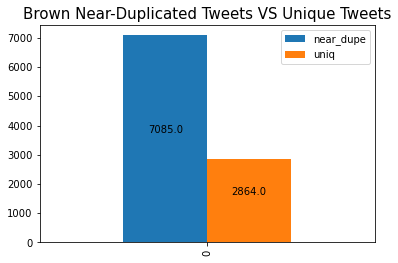

In [ ]:
ax=dic4.plot(kind = 'bar', fontsize=10)
ax.set_title('Brown Near-Duplicated Tweets VS Unique Tweets', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [ ]:
df_brown1 = l10.toPandas()
df_brown1['dupe_idx1']=list(zip(df_brown1.idA, df_brown1.idB))
new = df_brown1.drop(['distCol'], axis=1)
new.to_csv('gs://msca-bigdata-1/notebooks/gchai/df_brown1.csv', index = False)

### Self join in Approximate similarity and set 0.3 as near duplicate threshold.

In [107]:
l11=model4.approxSimilarityJoin(transa4, transa4, 0.3).filter("datasetA.id < datasetB.id").select(col("datasetA.id").alias("idA"),
            col("datasetB.id").alias("idB"),
            col("distCol"))

In [ ]:
g11=l11.groupBy("idA").count().toPandas()
g11.head()

,idA,count
0,29841,289
1,39713,222
2,61251,408
3,146915,237
4,162781,193


In [ ]:
dupe=len(g11.idA)
uniq=df_brownA.count()-dupe
dic4=pd.DataFrame.from_dict({'near_dupe': [dupe], 'uniq': [uniq]})
dic4

,near_dupe,uniq
0,6185,3764


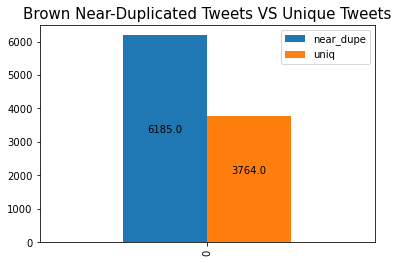

In [ ]:
ax=dic4.plot(kind = 'bar', fontsize=10)
ax.set_title('Brown Near-Duplicated Tweets VS Unique Tweets', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [ ]:
df_brown2 = l11.toPandas()
df_brown2['dupe_idx2']=list(zip(df_brown2.idA, df_brown2.idB))
new = df_brown2.drop(['distCol'], axis=1)
new.to_csv('gs://msca-bigdata-1/notebooks/gchai/df_brown2.csv', index = False)

### Self join in Approximate similarity and set 0.6 as near duplicate threshold.

In [ ]:
l12=model4.approxSimilarityJoin(transa4, transa4, 0.6).filter("datasetA.id < datasetB.id").select(col("datasetA.id").alias("idA"),
            col("datasetB.id").alias("idB"),
            col("distCol"))

In [ ]:
g12=l12.groupBy("idA").count().toPandas()
g12.head()

,idA,count
0,29841,289
1,39713,222
2,146915,237
3,162781,193
4,61251,409


In [ ]:
dupe=len(g12.idA)
uniq=df_brownA.count()-dupe
dic4=pd.DataFrame.from_dict({'near_dupe': [dupe], 'uniq': [uniq]})
dic4

,near_dupe,uniq
0,7739,2210


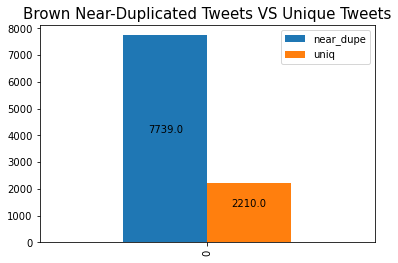

In [ ]:
ax=dic4.plot(kind = 'bar', fontsize=10)
ax.set_title('Brown Near-Duplicated Tweets VS Unique Tweets', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [ ]:
df_brown3 = l12.toPandas()
df_brown3['dupe_idx3']=list(zip(df_brown3.idA, df_brown3.idB))
new = df_brown3.drop(['distCol'], axis=1)
new.to_csv('gs://msca-bigdata-1/notebooks/gchai/df_brown3.csv', index = False)

## Now, let's prepare a table that include 100 pairs and compare their dup/non-dup results from the 3 thresholds 

In [ ]:
# check how many dupe pairs in each threshold
print('amount of dupe pairs by 0.5 threshold:',len(df_brown1.dupe_idx1))
print('amount of dupe pairs by 0.3 threshold:',len(df_brown2.dupe_idx2))
print('amount of dupe pairs by 0.6 threshold:',len(df_brown3.dupe_idx3))
print('diff dupe pairs between 0.5 and 0.3:',len(df_brown1.dupe_idx1)-len(df_brown2.dupe_idx2))
print('diff dupe pairs between 0.6 and 0.5:',len(df_brown3.dupe_idx3)-len(df_brown1.dupe_idx1))

amount of dupe pairs by 0.5 threshold: 376524
amount of dupe pairs by 0.3 threshold: 343627
amount of dupe pairs by 0.6 threshold: 442714
diff dupe pairs between 0.5 and 0.3: 32897
diff dupe pairs between 0.6 and 0.5: 66190


In [41]:
# 0.3 threshold has the least dupe pairs, first find dupe pairs that recognized in 0.5 threshold, not 0.3
z = list(set(df_brown1.dupe_idx1) - set(df_brown2.dupe_idx2))
len(z)

32897

In [42]:
#find dupe pairs that recognized in 0.6, not in 0.5
zz =list(set(df_brown3.dupe_idx3) - set(df_brown1.dupe_idx1))
len(zz)

66190

In [43]:
brown=brown.toPandas()
# sample 50 pairs from 0.3 threshold result
ex_brown1 = df_brown2.sample(50, random_state=1).drop(['dupe_idx2'],axis=1)

#sample 25 from pairs that recognized by 0.5 not 0.3
ex_brown2 = df_brown1[df_brown1['dupe_idx1'].isin(z)].sample(25, random_state=1).drop(['dupe_idx1'],axis=1)

#sample 25 from pairs that recognized by 0.6 not 0.5
ex_brown3 = df_brown3[df_brown3['dupe_idx3'].isin(zz)].sample(25, random_state=1).drop(['dupe_idx3'], axis=1)

table4=pd.concat([ex_brown1, ex_brown2, ex_brown3], axis=0)

In [44]:
table4['text1'] = [brown.loc[brown.id==i, "text"].values for i in list(table4.idA)] 
table4['text2'] = [brown.loc[brown.id==i, "text"].values for i in list(table4.idB)] 
table4['0.3threshold'] = ['Dupe']*50 + ['Non-Dupe']*50
table4['0.5threshold'] = ['Dupe']*75 + ['Non-Dupe']*25
table4['0.6threshold'] = ['Dupe']*100
table4=table4.reset_index(drop=True)
table4

,idA,idB,text1,text2,0.3threshold,0.5threshold,0.6threshold
0,69108,195141,"[(RT @ajplus: 507,000 people died in U.S. wars since 9/11, half of them in Iraq, says a Brown University study:,)]","[(RT @ajplus: 507,000 people died in U.S. wars since 9/11, half of them in Iraq, says a Brown University study:,)]",Dupe,Dupe,Dupe
1,80087,137858,"[(RT @valentina_gtrz: I grew up 15 minutes from Brown University and I still didn’t know that institution existed until the eighth grade. In…,)]","[(RT @valentina_gtrz: I grew up 15 minutes from Brown University and I still didn’t know that institution existed until the eighth grade. In…,)]",Dupe,Dupe,Dupe
2,4253,212061,"[(https://t.co/UNiY2Eg5Fs - Postdoctoral Fellow - Providence, Rhode Island, United States - Postdoctoral Fellowship at Brown University,)]","[(https://t.co/UNiY2Eg5Fs - Postdoctoral Fellow - Providence, Rhode Island, United States - Postdoctoral Fellowship at Brown University,)]",Dupe,Dupe,Dupe
3,35815,141256,"[(RT @KilfoylAndrew: Blessed to receive an offer from Brown University 🟤⚪️ @CoachW_Edwards @Cowboycoach2016 @247Sports @DemetricDWarren @Coac…,)]","[(RT @Diamond_Evans16: Blessed To Receive an Offer from Brown University #IvyLeague https://t.co/DRrMTSb1Xl,)]",Dupe,Dupe,Dupe
4,143199,211305,"[(RT @thehill: Brown University offers free tuition to college students from Puerto Rico https://t.co/g3Q3HBann5 https://t.co/xZpKjZ4ze1,)]","[(RT @thehill: Brown University offers free tuition to college students from Puerto Rico https://t.co/g3Q3HBann5 https://t.co/xZpKjZ4ze1,)]",Dupe,Dupe,Dupe
5,42325,57535,"[(RT @JesseKellyDC: Most people know @CNN was started by Ted Turner. What you may not know is Ted Turner went to Brown University, which was…,)]","[(RT @JesseKellyDC: Most people know @CNN was started by Ted Turner. What you may not know is Ted Turner went to Brown University, which was…,)]",Dupe,Dupe,Dupe
6,80136,131263,"[(RT @valentina_gtrz: I grew up 15 minutes from Brown University and I still didn’t know that institution existed until the eighth grade. In…,)]","[(RT @valentina_gtrz: I grew up 15 minutes from Brown University and I still didn’t know that institution existed until the eighth grade. In…,)]",Dupe,Dupe,Dupe
7,143630,194381,"[(https://t.co/UNiY2Eg5Fs - Postdoctoral Fellow - Providence, Rhode Island, United States - Postdoctoral Fellowship at Brown University,)]","[(https://t.co/UNiY2Eg5Fs - Postdoctoral Fellow - Providence, Rhode Island, United States - Postdoctoral Fellowship at Brown University,)]",Dupe,Dupe,Dupe
8,46054,54355,"[(RT @DavidKlion: This is the Yorktown Heights (very nice area) home @Ocasio2018 grew up in before going off to Ivy League Brown University.…,)]","[(RT @feraljokes: This is the Yorktown Heights (very nice area) home @Ocasio2018 grew up in before going off to Ivy League Brown University.…,)]",Dupe,Dupe,Dupe
9,123563,173850,"[(RT @valentina_gtrz: I grew up 15 minutes from Brown University and I still didn’t know that institution existed until the eighth grade. In…,)]","[(RT @valentina_gtrz: I grew up 15 minutes from Brown University and I still didn’t know that institution existed until the eighth grade. In…,)]",Dupe,Dupe,Dupe


In [126]:
table4.to_csv('gs://msca-bigdata-1/notebooks/gchai/brown_table.csv', index = False)

# Summary:

The 25 pairs example that recognized by threshold 0.5 not 0.3 are all near-duplicated contents. The 25 pairs example that recognized by threshold 0.6 not 0.5 are also near-duplicated contents. We can see the differene in the last 25 rows are adding more people in the tag, so the tagged person name caused this non-dupe result. However, the contents are pretty the same! Thus I recommend 0.6 threshold for Brown Unique VS Near-duplicate tweets analysis. 


